Подготовить данные для модели:
    
   Анализ данных, необходимые корректировки. 
1. Обработать пропуски. 
2. Оценить выбросы. 
3. Корреляция. 
4. Тест на нормальность распределения.
5. Масштабировать данные.



In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import OrdinalEncoder


with open('credit_train.csv', newline='', encoding='Windows-1251') as f:
    # Открываем исходный файл. Т.к он разделен точками с запятой сначала
    #убираем запятые, меняем их на точки, потом заменяем точки с запятой на запятые.    
    str = f.read().replace(",", "." ) 
    str = str.replace(";",",")
    # Создаем файл с разделением запятыми для нормального открытия питоном:
    with open('train_ready.csv','w',  encoding='Windows-1251') as file2:    
        file2.write(str)
        
# Создаем усеченный датафрейм для дальнейшей обработки. Удаляем пропуски:
df = pd.read_csv("train_ready.csv",encoding='Windows-1251' ,on_bad_lines='skip',
                    index_col='client_id' ,
                    usecols=[0,2, 5,8,11]
                    )
df = df.dropna()
# Создаем расширенный датафрейм для дальнейшей обработки:
df_full = pd.read_csv("train_ready.csv",encoding='Windows-1251' ,on_bad_lines='skip',
                    index_col='client_id' ,  usecols=[0,2, 5,8,10,11]
                    )
df_full = df_full.dropna()



#Для обработки "living_region" обработаем эту колонку: 1) Создадим словарь удаляемых слов:
#change_dict = {'ОБЛАСТЬ':'','ОБЛ':'','КРАЙ':'','АО':'','АВТОНОМНЫЙ ОКРУГ':'','РЕСПУБЛИКА':'','РЕСП.':'','РЕСП':'','.':''}
change_dict = {'ОБЛАСТЬ':'','ОБЛ':'','КРАЙ':'','АО':'','АВТОНОМНЫЙ ОКРУГ':'','РЕСПУБЛИКА':'','РЕСП.':'','РЕСП':''}


df_full = df_full.replace(to_replace =change_dict, regex = True)
df_full['living_region'] = df_full['living_region'].str.replace(" ", "")
df_full['living_region'] = df_full['living_region'].str.slice(0,8)

print("исходный массив " , len(df_full))



print("массив с отброшенными пропусками " , len(df_full))
print(df_full)

исходный массив  170545
массив с отброшенными пропусками  170545
            age  credit_sum  score_shk living_region  monthly_income
client_id                                                           
8          26.0    47878.00   0.512525      МОСКОВСК         60000.0
10         32.0    26268.00   0.465026      СТАВРОПО         39500.0
11         26.0    16793.00   0.445430      САНКТ-ПЕ         36000.0
12         26.0    18936.00   0.455774      БАШКОРТО         30000.0
13         37.0    42289.00   0.691609      АРХАНГЕЛ         70000.0
...         ...         ...        ...           ...             ...
170742     27.0    64867.00   0.535257      ТАТАРСТА         40000.0
170743     24.0    17640.00   0.573287      САНКТ-ПЕ         30000.0
170744     31.0    27556.47   0.416098      ПРИМОРСК         40000.0
170745     53.0     6189.00   0.482595      ПЕНЗЕНСК         31000.0
170746     49.0    12787.00   0.316087      МОСКОВСК         40000.0

[170545 rows x 5 columns]


Вывод: Т.к пропуски составляют менее 6 процентов данных, удаляем строки с пропусками.

Сделаем тест на нормальность по двум столбикам методом Шапиро-Уилка:

In [2]:
import matplotlib.pyplot as plt
from scipy import stats

stat,p = stats.shapiro(df_full["credit_sum"],nan_policy='omit')
print("  credit_sum, statistics:" " %.2f" %stat," p-value", "%.2f" % p)

stat,p = stats.shapiro(df_full["monthly_income"],nan_policy='omit')
print("  monthly_income, statistics:", "%.2f" %stat," p-value", "%.2f" % p)

stat,p = stats.normaltest(df_full["credit_sum"],nan_policy='omit')
print("%.2f" % stat,"%.2f" %  p)


  credit_sum, statistics: 0.88  p-value 0.00
  monthly_income, statistics: 0.73  p-value 0.00
45095.89 0.00


c:\Users\Антон\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 170545.
  res = hypotest_fun_out(*samples, **kwds)


В обоих случаях p-value меньше 0.05, поэтому данные не являются нормальными.

Данные credit_sum и mounthly_income в виде частот:

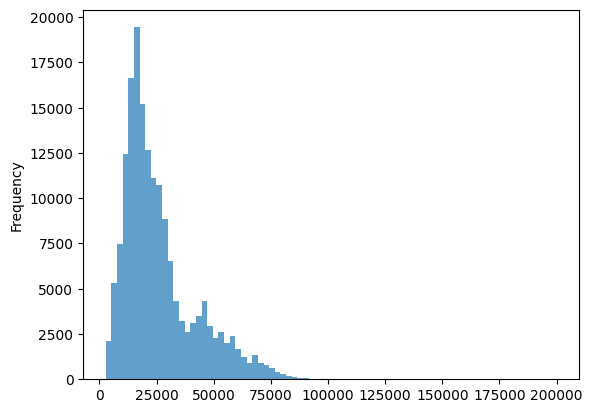

In [4]:
ax = df['credit_sum'].plot.hist(bins=80, alpha=0.7)


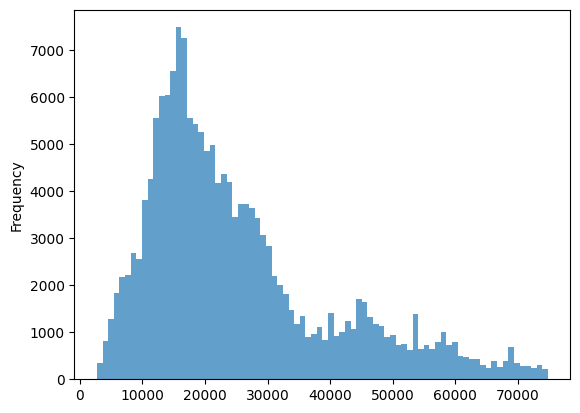

In [5]:

#Удаляем выбросы и смотрим, как изменится картинка частот:
df_no_outliers = df[(np.abs(stats.zscore(df))<3).all(axis=1)]
ax = df_no_outliers['credit_sum'].plot.hist(bins=80, alpha=0.7)

np.float64(35000.0)

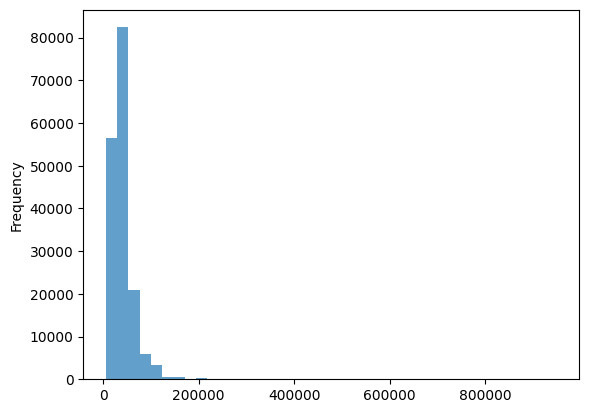

In [6]:
# Строим график частот для месячного дохода:
bx = df['monthly_income'].plot.hist(bins=40, alpha=0.7)
df['monthly_income'].median()


Данные графики частот также говорят о том, что данные не нормально распределены. Кроме того есть выбросы, от которых нужно избавляться:

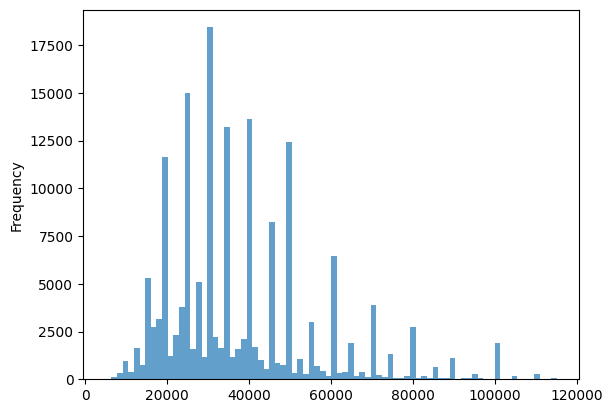

In [7]:
bx = df_no_outliers['monthly_income'].plot.hist(bins=80, alpha=0.7)

Здесь хорошо видно, что данные "разорваны" по причине круглых сумм зарплат, т.е 20К, 25К, 30К, 35К и т д. Данные по зарплате распределены не нормально.

Тест на корреляцию

            age  credit_sum  score_shk  monthly_income  \
client_id                                                
8          26.0    47878.00   0.512525         60000.0   
10         32.0    26268.00   0.465026         39500.0   
11         26.0    16793.00   0.445430         36000.0   
12         26.0    18936.00   0.455774         30000.0   
13         37.0    42289.00   0.691609         70000.0   
...         ...         ...        ...             ...   
170742     27.0    64867.00   0.535257         40000.0   
170743     24.0    17640.00   0.573287         30000.0   
170744     31.0    27556.47   0.416098         40000.0   
170745     53.0     6189.00   0.482595         31000.0   
170746     49.0    12787.00   0.316087         40000.0   

           living_region_.ВЛАДИМИ  living_region_.КИРОВСК  \
client_id                                                   
8                           False                   False   
10                          False                   False   
1

<Axes: >

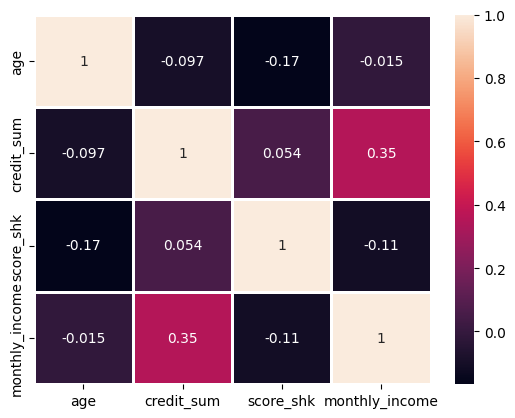

In [8]:
import seaborn as sb


df_head = df_full.head(200)

df_pandas_encoded = pd.get_dummies(df_full, columns=['living_region'], drop_first=True)

print(df_pandas_encoded)
df_pandas_encoded.to_csv('df_encoded.csv')

corr_matrix = df.corr()

sb.heatmap(corr_matrix,annot=True, linewidths=1)



Вывод: в данной выборке столбцов нет коррелированных данных

In [9]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_temp = df
scaler = StandardScaler()
print(scaler.fit(df_temp))
print(scaler.mean_)
print(scaler.transform(df_temp))

scalerminmax = MinMaxScaler(feature_range=(-1,1))
print(scalerminmax.fit(df))
print(scalerminmax.data_max_)
print(scalerminmax.transform(df))

StandardScaler()
[3.64974083e+01 2.60952623e+04 4.69473339e-01 4.01387282e+04]
[[-0.99538371  1.34173679  0.34644883  0.79303795]
 [-0.42645259  0.01064001 -0.03578899 -0.02550369]
 [-0.99538371 -0.57298526 -0.19348352 -0.1652547 ]
 ...
 [-0.52127444  0.09000503 -0.42952638 -0.00553926]
 [ 1.56480633 -1.22615279  0.1055937  -0.36489901]
 [ 1.18551892 -0.81974018 -1.23434306 -0.00553926]]
MinMaxScaler(feature_range=(-1, 1))
[7.100000e+01 2.000000e+05 1.128291e+00 9.500000e+05]
[[-0.69811321 -0.54231892 -0.0915021  -0.88359788]
 [-0.47169811 -0.76141617 -0.17569847 -0.92698413]
 [-0.69811321 -0.85748033 -0.21043419 -0.93439153]
 ...
 [-0.50943396 -0.74835277 -0.26242787 -0.92592593]
 [ 0.32075472 -0.96499108 -0.14455579 -0.94497354]
 [ 0.16981132 -0.89809595 -0.4397066  -0.92592593]]


Выводы: Стандартный скалер выводит выбросы за диапазон -1 -1 Это может быть удобно для удаления выбросов.

МинМакс Скалер делает простое масштабирование.

Задача: есть данные, что тест на болезнь дает результат с вероятностью в 98%. Число больных в популяции у нас 1%. 
Вопрос - с какой вероятностью положительный тест будет положительным при случайном тестировании.  